# When Prediction Fails

## When all you have is a Hammer...

Between 2015 and 2020, Machine Learning went through a massive surge. Its proven usefulness in the fields of computer vision and natural language understanding, coupled with an initial lack of professionals in the area, provided the perfect opportunity for a machine learning teaching industry. Figures like Andrew Ng and Sebastian Thrun managed to teach machine learning to the world at rock bottom prices. At the same time, on the software side, it became increasingly easier to fit a complex machine learning model (as you've already seen by the very few lines of code it took us to write an ML in the previous chapter). Tutorials about how to make intelligent systems sprung all over the internet. The cost of entry in ML plumend.

![img](./data/img/when-prediction-fails/ml-in-5.png)

Building ML became so simple that you didn't even need to know how to code very well (and I'm living evidence of that), nor the math behind the algorithms. In fact, you could build wonders with the following 5 lines of Python.

```python
X_train, y_train, X_test, y_test =  train_test_split(X, y)

## instantiate the machine learning model
model = MachineLearningModel()

## Fit the ML model
model.fit(X_train, y_train)

# Make predictions on unseen data
y_pred = model.predict(X_test)

# Evaluate the quality of predictions
print("Performance", metric(y_test, y_pred))
```

For the most part, this is an amazing thing! I'm all in for taking valuable content and making it available. However, there is also a dark side to all of this. This new wave of data scientists were trained mostly in predictive modeling, since that is what ML primarily focuses on solving. As a result, whenever those data scientists encountered a business problem, they tried to tackle it with, not surprisingly, predictive models. When they were indeed prediction problems, like the one we saw in the previous chapter, the data scientist usually succeeded and everyone got happy. However, there is an entire class of problems that are simply not solvable with prediction techniques. And when those appeared, the data scientists usually failed miserably. These are problems that are framed like "how much can I increase Y by changing X".

From my experience, this other type of problem is what management usually cares the most about. They often want to know how to increase sales, decrease cost or bring in more customers. Needless to say, they are not very happy when a data scientist comes up with an answer to how to predict sales instead of how to increase it. Sadly, when everything the data scientist knows is predictive models, this tends to happen a lot. As a boss of mine once told me: "when all you have is a hammer, everything starts to look like a thumb". 

Like I've said, I'm all in for lowering the cost of knowledge, but the current Data Scientist curriculum has a huge gap.  I think that my job here is to fill in that gap and equip you to solve this other class of problems. As you might have guessed, they are causal in nature. What you are trying to do is estimate how something you can control (advertisement, price, customer service) affects or causes something you want to change (sales, number of customers, PNL). But before showing you how to solve those, I want to show you what happens when you treat them like prediction problems and try to solve them with the traditional ML toolkit. The reason for that is that DS often says to me "OK, but although tackling causal problems with prediction tools is not the best idea, it surely helps something, no? It could hurt trying". Well, as it turns out, it can. You better understand this before you go on hammering your own thumb.

In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import gradient_boosting
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")

from nb18 import ltv_with_coupons

## Who Wants a Coupon?

To make matters more relatable, let's continue with the example we used in the previou chapter, but with a little little twist to it. Previously, we were trying to figure out the profitable from the non profitable customers. We framed that as a prediction problem: predicting customer profitability. We could then build a machine learning model for that and use it to choose who we would do business with: only the customers we predicted to be profitable. In other words, our goal was to separate the profitable from the non-profitable, which we could do with a predictive model.

Now, you have a new task. You suspect that giving coupons to new customers increases their engagement with your business and makes them more profitable in the long run. That is, they spend more and for a longer period. Your new assignment is to figure out how much the coupon value should be (zero included). Notice that, with coupons, you are essentially giving away money for people to spend on your business. For this reason, they enter as a cost in your book account. Notice that if the coupon value is too high, you will probably lose money, since customers will buy all they need using only the coupons. On the flip side, if it's too low (or zero), you are not even giving coupons. 

The function `ltv_with_coupons` generates transaction data for us. As you can see, they have the same format as the one we saw previously, with one row per customer, a column for the cost of acquisition and columns for the transactions between day 1 and 30. 

In [2]:
transactions, customer_features = ltv_with_coupons()

print(transactions.shape)
transactions.head()

(10000, 32)


,customer_id,cacq,day_0,day_1,day_2,day_3,day_4,day_5,day_6,day_7,...,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29
0,0,-110,0,0,0,0,1,0,0,3,...,0,0,0,10,0,0,0,0,0,0
1,1,-61,0,2,3,0,0,0,0,2,...,0,2,0,0,0,31,0,0,0,0
2,2,-8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,-41,0,0,0,22,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0


As for the other part of the data, again, we have a customer identifier, the region the customer lives, the customer income and the customer age. In addition, we now have a variable that is `coupons`, which tells us how much we've given in coupons for that customer.

In [3]:
print(customer_features.shape)
customer_features.head()

(10000, 5)


,customer_id,region,income,coupons,age
0,0,1,1025,5,24
1,1,49,1649,5,26
2,2,7,2034,15,33
3,3,29,1859,15,35
4,4,0,1243,5,26


To process this data to a single dataframe, we will sum all the columns in the first table (that is, summing `CACQ` with the transactions).This will give us the `net_value` as it was computed in the previous chapter. After that, we will update the `net_value` to include the coupon cost.

In [4]:
def process_data(transactions, customer_data):

    profitable = (transactions[["customer_id"]]
                  .assign(net_value = transactions
                          .drop(columns="customer_id")
                          .sum(axis=1)))

    return (customer_data
            .merge(profitable, on="customer_id")
            ## include the coupons cost
            .assign(net_value = lambda d: d["net_value"] - d["coupons"]))

customer_features = process_data(transactions, customer_features)
customer_features.head()

,customer_id,region,income,coupons,age,net_value
0,0,1,1025,5,24,-100
1,1,49,1649,5,26,-16
2,2,7,2034,15,33,18
3,3,29,1859,15,35,-45
4,4,0,1243,5,26,-18


This processed data frame has all that we need. It has our target variable `net_value`, it has our customer features `region`, `income` and `age`, and it has the lever we want to optimise for: coupons. Just to begin understanding how coupons can increase `net_value`, let's look at how they were given away.

In [5]:
customer_features.groupby("coupons")["customer_id"].count()

coupons
0      458
5     4749
10    4154
15     639
Name: customer_id, dtype: int64

We can see that most of the coupons that were handed out had a value of 5 BRL, followed by the coupons with 10 BRL in value. We gave very few 15 BRL coupons or no coupons at all (zero value). This is indicative that they where not given randomly. To check that, let's see the correlation between the other variable and coupons. 

In [6]:
customer_features.corr()[["coupons"]]

,coupons
customer_id,0.002239
region,-0.025821
income,0.001236
coupons,1.000000
age,0.897308
net_value,0.077483


That's interesting. It looks like the older the person, the higher the probability he or she will receive a coupon. Also, it looks like the correlation between couponts and net value is positive, so the higher the coupon value, the higher the net income. Now, I wouldn't trust that too much, as it goes against our business intuition. We have very strong reasons to believe that if we give too high of a coupon value, the `net_income` will go down. So, perhaps what is happening here is that we haven't explored the high coupon values to reach that decreasing returns point. Let's remember this and investigate it further.

At this point in the analysis, **if this was a prediction problem** , we would probably split the dataset into a training and a test set to, respectively, build and evaluate some policies. However, this is NOT a prediction problem. The final goal here is not to get a good prediction on customer profitability. Instead, it is to figure out the optimal coupon strategy. To evaluate this optimization, we would have to know how things would have played out if we have given different coupons than the ones that were given. This is the sort of counterfactual "what if'' question we've been studying under causality. But if we can't simply do cross validation (or train test split) what can we do to evaluate our optimization strategy? The real answer is very involved and so important that it deserves its own chapter. For now, since all this data is simulated, we can re-generate the data but change the coupon parameters. Then, we can observe how the `net_value` would have played out under a different coupon policy. Notice that this sort of evaluation is not feasible in real life. It is only pedagogical so you can see the point I'm making. Let's see this in practice and I think it will become more clear.

## Simple Policy

As always, the first thing we should do whenever we encounter a new data problem is to ask ourselves "what is the simplest thing I can do that will already bring value?". For, this specific case, the simplest thing is to look back on the data that we have and estimate the `net_value` for each coupon value. Then, check which coupon value is generating the highest `net_value` and give only that coupon value for every customer. 

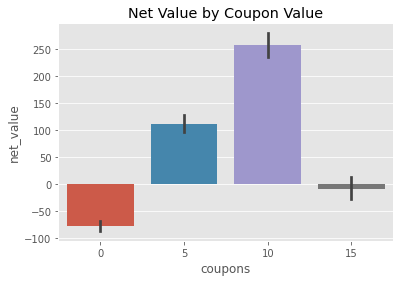

In [7]:
sns.barplot(data=customer_features, x="coupons", y="net_value")
plt.title("Net Value by Coupon Value");

Doing that analysis, we can see that, on average, we lose money when the coupon value is 0 or 15 and we gain money for coupons of 5 and 10 BLR. The highest average `net_income` appears when we have 10 BLR coupons, yielding us about 250 BLR in `net_value` per customer. Naturally then, the simplest thing we can try is to give everyone 10 BLR in coupons and see how that would play out.

To do that, the function `ltv_with_coupons` accepts as argument a 10000 array that contains the desired coupon for each of the 10000 customers on our database. To create this array, we will generate an array of ones with `np.ones` the size of our `coupons` array (10000) and multiply it by 10. Then, we will pass this array to the `ltv_with_coupons`. This will generate a new dataset exactly like the one we had previously, but with every coupon value set to 10. We then process this data to get the net value under this newly proposed policy.

In [8]:
simple_policy = 10 * np.ones(customer_features["coupons"].shape)

transactions_simple_policy, customer_features_simple_policy = ltv_with_coupons(simple_policy)

customer_features_simple_policy = process_data(transactions_simple_policy,
                                               customer_features_simple_policy)

customer_features_simple_policy.head()

,customer_id,region,income,coupons,age,net_value
0,0,1,1025,10,24,17
1,1,49,1649,10,26,142
2,2,7,2034,10,33,9
3,3,29,1859,10,35,-40
4,4,0,1243,10,26,32


Just as a sanity check, let's see if the first few customers have that same feature as before. For the first one, the region is 1, the income is 1025 and the age is 24. If we scroll up a bit, we can see that it matches what we had before, so we are good to go. Also, we can check that all the coupon values are indeed 10 BRL. 

To evaluate this policy, we can simply take the average net_value. Again, this is only possible with simulated data, where we can regenerate the same data under different coupons values.

In [9]:
simple_policy_gain = customer_features_simple_policy["net_value"].mean()
simple_policy_gain

464.556

As we can see, this simple policy is telling us we can get, on average, 464 BRL for each customer if we give them a 10 BLR coupon. This is massive. If we can have only 1000 customers we will already make more than almost half a million BRL! But can we do better? What if we use our shiny machine learning hammer on this problem? Let's try this next.

## Policy With Model

To use ML, we will adapt what we did in the previous chapter. The idea is to build a ML model that predicts `net_value`, just like before, take those predictions and bin them into a defined number of bands. Then, we will partition the data into those bands. Essentially, we are splitting the customer by their predicted `net_value`. Customers that we think will generate the roughly same `net_value` will end up in the same bin or group. Finally, for each group, we will see which coupon value yields the maximum `net_value`. We are doing the same thing as in the simple policy, but now within the groups defined by a prediction band. The intuition behind this is the following: we know that, on average, 10 BLR coupons performed better. However, it is possible that for some group of customers, another value is even better than 10 BRL. Maybe, 10 BLR is the optimal strategy for most of the customers, but not all. If we can identify the ones where the optimal value is different, we can build a coupon strategy better than the simple one we did above.

![img](./data/img/when-prediction-fails/model-opt.png)

This is what we call a personalization problem. We will talk more about it, but just to peak your interest, in formal terms, we can leverage personalization when we have more than one strategy to choose from and at least one of them is not the overall best strategy, but it is the best in a subset of the targeted population. 

But back to the example. The first thing we need is a function that fits our predictive model and also fits the prediction bands. This function will return another function, a prediction function that will take a dataframe and add both prediction and band columns.

In [10]:
def model_bands(train_set, features, target, model_params, n_bands, seed=1):
    
    np.random.seed(seed)
    
    # train the ML model
    reg = ensemble.GradientBoostingRegressor(**model_params)
    reg.fit(train_set[features], train_set[target])
    
    # fit the bands
    bands = pd.qcut(reg.predict(train_set[features]), q=n_bands, retbins=True)[1]
    
    def predict(test_set):
        # make predictions with trained model
        predictions = reg.predict(test_set[features])
        
        # discritize predictions into bands.
        pred_bands = np.digitize(predictions, bands, right=False) 
        return test_set.assign(predictions=predictions,
                               # cliping avoid creating new upper bands
                               pred_bands=np.clip(pred_bands, 1, n_bands))
    
    return predict

To evaluate the quality of our predictions, we will split the dataset into a training and a testing set. Notice here that we are evaluating the quality of the prediction, NOT of the policy. This is just to see if our model is any good or just outputting random useless stuff 

In [11]:
train, test = train_test_split(customer_features, test_size=0.3, random_state=1)

Now, let's train our model and make 5 bands with its predictions.

In [12]:
model_params = {'n_estimators': 150,
                'max_depth': 4,
                'min_samples_split': 10,
                'learning_rate': 0.01,
                'loss': 'ls'}

features = ["region", "income", "age"]
target = "net_value"

np.random.seed(1)
model = model_bands(train, features, target, model_params, n_bands=5)

After training our model, we can use it to make predictions, passing it a dataframe. The result will also be a data frame with 2 new columns: `predictions` and `pred_bands`.

In [13]:
model(train).head()

,customer_id,region,income,coupons,age,net_value,predictions,pred_bands
2228,2228,3,567,5,27,-144,-17.433264,1
5910,5910,35,647,5,25,-62,-17.433264,1
1950,1950,43,2953,15,33,-142,326.474165,5
2119,2119,20,2860,5,27,-92,43.624013,3
5947,5947,45,589,5,26,-94,-6.570707,2


To see the predictive power of our model, we can look at the \\(R^2\\) for both training and test sets.

In [14]:
print("Train Score:, ", r2_score(train["net_value"], model(train)["predictions"]))
print("Test Score:, ", r2_score(test["net_value"], model(test)["predictions"]))

Train Score:,  0.3556912122241016
Test Score:,  0.3301683687600404


But this performance is only the predictive performance. What we really want to know is if this model can make us money. To do so, let's make a policy. The idea here is very similar to what we saw in the previous chapter. We will group the customers by model band. Then, for each type of customer as defined by the bands, we will see which decision - coupon value in our case - is the best one. To do so, we can group our data by prediction band and coupon value and plot the `net_value`.

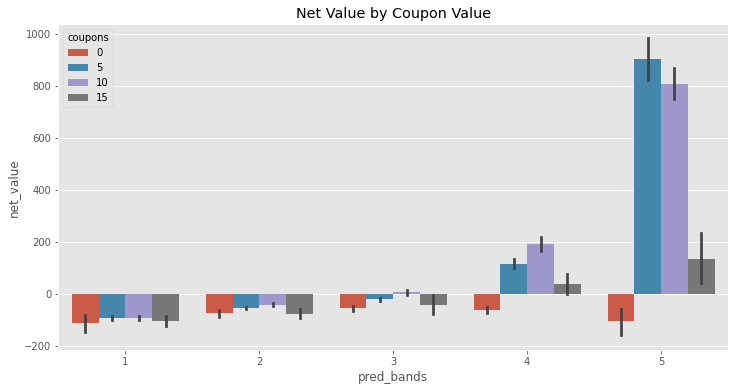

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(data=model(customer_features), x="pred_bands", y="net_value", hue="coupons")
plt.title("Net Value by Coupon Value");

This plot is very interesting. Notice how the optimal decision changes across prediction bands. For band 1, 2, 3 and 4, the best thing to do is to give 10 BLR in coupons. And for band 5, the best thing is 5 BRL coupons. This means that this policy is very much like the simple one, except for the last band. There is a caveat, though. For band 5 and 1, if we take the confidence interval into account, we can't say for sure which one is the best strategy. We could come up with some technique to give both coupons values which we think is the best, but, for the sake of simplicity, let's just give the coupon which yielded the maximum `net_value` in each band.

We can code that policy with a couple of `if ... then ...` statements, but I'll show a more general approach. First, we will group our customers by band and coupon value and take the `net_value` for each group, much like the plot above.

In [16]:
pred_bands = (model(customer_features)
              .groupby(["pred_bands", "coupons"])
              [["net_value"]].mean()
              .reset_index())

pred_bands.head(7)

,pred_bands,coupons,net_value
0,1,0,-112.676768
1,1,5,-94.653568
2,1,10,-91.997611
3,1,15,-104.333333
4,2,0,-74.698113
5,2,5,-54.582198
6,2,10,-42.217778


Then, we will group only by band and take the `net_value` rank for each row. This will order the rows according to the average `net_value`, where 1 is the worst net value in that band and 4 is the best net value.

In [17]:
pred_bands["max_net"] = (pred_bands
                         .groupby(['pred_bands'])
                         .agg({"net_value": "rank"}))


pred_bands.tail(8)

,pred_bands,coupons,net_value,max_net
12,4,0,-62.371429,1.0
13,4,5,115.491844,3.0
14,4,10,189.922705,4.0
15,4,15,37.584677,2.0
16,5,0,-105.000000,1.0
17,5,5,901.980854,4.0
18,5,10,805.830830,3.0
19,5,15,134.088608,2.0


Next, we will keep only the greatest `net_value` per band.

In [18]:
best_coupons_per_band = pred_bands.query("max_net==4")[["pred_bands", "coupons"]]

best_coupons_per_band

,pred_bands,coupons
2,1,10
6,2,10
10,3,10
14,4,10
17,5,5


Finally, to build our policy, we will take that small table above and join it back on the original table using the band as the key. This will pair each row in the original dataset with what we think is optimal coupon value, acording to this policy. The, we sort the rows according to the `customer_id` so that we keep the same ordering we had previusly.

In [19]:
coupons_per_id = (model(customer_features)
                 .drop(columns=["coupons"])
                 .merge(best_coupons_per_band, on="pred_bands")
                 [["customer_id", "coupons"]]
                 .sort_values('customer_id'))

coupons_per_id.head()

,customer_id,coupons
0,0,10
2038,1,10
3982,2,10
2039,3,10
5960,4,10


Finally, to build our policy, we will take that small table above and join it back on the original table using the band as the key. This will pair each row in the original dataset with what we think is optimal coupon value, according to this policy. Then, we sort the rows according to the `customer_id` so that we keep the same ordering we had previously. This is important for evaluation, since `ltv_with_coupons` takes as argument the coupon value in the order of the original dataframe.

In [20]:
transactions_policy_w_model, customer_features_policy_w_model = ltv_with_coupons(
    coupons_per_id[["coupons"]].values.flatten()
)

customer_features_policy_w_model = process_data(transactions_policy_w_model,
                                                customer_features_policy_w_model)

customer_features_policy_w_model.head()

,customer_id,region,income,coupons,age,net_value
0,0,1,1025,10,24,-77
1,1,49,1649,10,26,-9
2,2,7,2034,10,33,9
3,3,29,1859,10,35,49
4,4,0,1243,10,26,16


Just doing a sanity check again, we can see that the first customer is still the one with region 1, income 1025 and age 24. Now, to evaluate our policy, we can see the average `net_value` mean for this new dataset, where the coupons were given as we defined by the policy. Again, remember that this is seeing how things would have played out if we had the exact same customers, but we gave them coupon values according to this policy we've defined. This is only possible to do with simulated data, where we can go back and regenerate everything changing only one parameter. 

In [21]:
policy_w_model_gain = customer_features_policy_w_model["net_value"].mean()
policy_w_model_gain

366.891

Not bad. We can expect to get 366 per customer with this model policy. But do you remember how much we were making with the simple policy? Well, the last thing to do is to compare this model based policy with that simple policy.

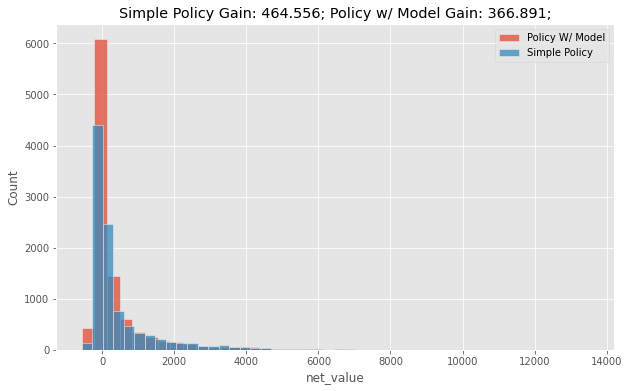

In [22]:
plt.figure(figsize=(10,6))
sns.histplot(data=customer_features_policy_w_model, bins=40,
             x="net_value", label="Policy W/ Model", color="C0")
sns.histplot(data=customer_features_simple_policy, bins=40,
             x="net_value", label="Simple Policy", color="C1")
plt.legend()
plt.title(f"Simple Policy Gain: {simple_policy_gain}; Policy w/ Model Gain: {policy_w_model_gain};");

Here is where most Data Scientists fall off the chair. The policy with the model has an average `net_income` which is 100 BRL worse than that of the simple policy. How can a model that is good at predicting `net_value` not be good for a strategy that aims to maximize `net_value`? Surely, there must be some bug at the code. You are clearly mistaken. This cannot be! Well, as it turns out, there is a perfectly reasonable and simple explanation for it. However, the answer to this question is so important that I think it is worth going a bit deeper into it.

## Hammering Your Thumb with Predictions

The short answer lies in understanding what we want with this policy, namely, to optimize `net_value` by playing with the coupon values. If we were to put it in an image, it's not crazy to think that `net_value` will have a quadratic shape on coupons: as we increase the coupon value `net_value` first increases, then it reaches a maximum point. After that, any additional coupon value will cost more than the value it brings.

![img](./data/img/when-prediction-fails/opt-deriv.png)

Finding the optimal coupon value is then equivalent to finding the maximum of the `net_value` function. We can do this by differentiating the function and setting it to zero (second plot). However, real world data doesn't come with an underlying function we can differentiate. In practice, what we do is test multiple coupon values and see which one yields the best `net_value`. This is exactly what our simple policy does. One VERY important thing to notice here is that this technique assumes that there is a causal effect from coupon value to `net_value`. In other words, it must be the case that coupons causal influences `net_value`, otherwise we couldn't use it as an optimization lever.

Contrast this to what the model based policy does. First, the model based policy fits a machine learning model to predict `net_value`. Then, it partitions the space according to the predictions. If the model is good, this is approximately equal to partitioning the space by `net_value` itself, just like in the following plot.

![img](./data/img/when-prediction-fails/model-opt.png)

The better the prediction, the more this partitioning of the space approaches partitioning on the target variable, `net_income`. Pay very close attention to what happens when you do that. Essentially, you are splitting the data into sets where `net_value`, the thing you've predicted, doesn't change! And that makes total sense. If your model is good at predicting, groups of points that have the same prediction will also have the same `net_value`. 

So far, so good, but look at what this does to the perceived function of `net_value` on coupons. It flattens it to have no slope at all. From the predictive point of view, this is awesome. It means that your model has captured all the variation on `net_income`. However, from the policy perspective, this is terrible, because there is no variance in `net_income` left for us to see how it would change given different coupon values. Without this variance in `net_income`, it would look like changing the coupon values has no effect on `net_income`, leaving us no room for optimization. By the way, this is a general phenomenon that has nothing to do with the specific quadratic shape we are using here. I'm only using an example to make it more concrete.

To summarize it in more general terms, whenever we want to optimise some \\(Y\\) variable using some \\(T\\) variable, predicting \\(Y\\) will not only not help, it will hurt our policy, since data partitions defined by the prediction will have limited \\(Y\\) variance, hindering our capacity to estimate how \\(T\\) changes \\(Y\\), \\(\frac{\delta Y}{\delta T} \\).

The key to fixing this mistake lies in adjusting our objective to what we really want. Instead of estimating \\(Y\\) out of \\(X\\), which is what prediction does, we need to estimate \\(\frac{\delta Y}{\delta T} \\) out of \\(X\\). Easier said than done. As you might have guessed already, this precisely what causal inference does. And, as it is natural of causal problems, we can't observe our quantity of interest \\(\frac{\delta Y}{\delta T} \\). You simply cannot observe how `net_income` would change if we changed the coupon value because we only observe one instance of a coupon per customer. We can never know what would have happened under some different coupon value had taken place (unless we use simulated data, of course. But that's only useful for teaching purposes).

This characteristic of causal problems leads to further questions: how can I know if my model is any good if I can't see what it is supposedly estimating? How can I validate a model like that? Those are fair questions and we shall answer them in time. Meanwhile, keep in mind that, as we change our focus from estimating \\(Y\\) to estimating \\(\frac{\delta Y}{\delta T}\\), lots of things will have to change accordingly and the traditional ML toolkit will need some adaptation.

Finally, before ending this chapter, I just wanted to talk about something I've been sweeping under the rug, which is the presence of bias. For both our simple and model based policy, we saw what coupon value was associated with the maximum `net_value`. However, we've never tested if this association was causal or not. For example, we know that, overall, 10 BRL coupons was associated with higher `net_value`. But what if our data was such that only the richer customers got such a coupon? Here, we've completely ignored the possibility of bias. I know that, but considering it would make this already complex topic even more complicated. But rest assured if this is bothering you. I'll address bias as we move forward to more real life examples. 

## Key Ideas 

We saw how there is a whole range of problems that are not solvable with traditional, predictive Machine Learning. Those problems are optimization ones, with a causal component, usually framed as "how should I set this thing a can control, T (price, number of phone calls, discount, ...), in order to optimize this metric, Y (profits, customer satisfaction, conversion, costs…)". When that is the case, predictive models can do more harm than good. 

To prove this point, we walked through an example where we needed to find the best coupon value. The first thing that we tried was to look at past data and see which coupon value led to the highest revenue. Then, we took that supposedly optimal value and gave it to every customer. This approach answers what is the best coupon value (treatment, in causal terms), on average. That is, if we were to pick only one fixed coupon, which should be its value. But we don't have such a restriction. If it turns out to be the case that some customers respond better to lower valued coupons and some respond better to higher ones, we could personalise the coupon for each customer. To do so, we tried to build a predictive ML model, a model that predicted the value each customer would bring. Then, we tried to personalize the model's predictions. We grouped the customers according to the predictions and for each group, we found which coupon value was the best one. Then, we tried using that learned value as a coupon strategy. However, we found that it performed worse than. The simple strategy of giving the same best coupon value for everyone. In other words, our ML model failed to separate customers that responded better or worse to coupon value. 

Notice that the problem we are trying to solve here is one of **personalization**. In our case, it was trying to figure out which coupon value is best for each customer. More generally, it is framed as "which is the best decision \\(T\\) and can take for each customer \\(i\\) so that I can maximise \\(Y_i\\) across all customers". This is not an easy problem to solve. But we can solve it with the help of causal inference. The rest of the book focuses on how to deal with that.

## Key Ideas 

We saw how there is a whole range of problems that are not solvable with traditional, predictive Machine Learning. Those problems are optimization ones, with a causal component, usually framed as "how should I set this thing a can control, T (price, number of phone calls, discount, ...), in order to optimize this metric, Y (profits, customer satisfaction, conversion, costs…)". When that is the case, predictive models can do more harm than good. 

To prove this point, we walked through an example where we needed to find the best coupon value. The first thing that we tried was to look at past data and see which coupon value led to the highest revenue. Then, we took that supposedly optimal value and gave it to every customer. This approach answers what is the best coupon value (treatment, in causal terms), on average. That is, if we were to pick only one fixed coupon, which should be its value. But we don't have such a restriction. If it turns out to be the case that some customers respond better to lower valued coupons and some respond better to higher ones, we could personalise the coupon for each customer. To do so, we tried to build a predictive ML model, a model that predicted the value each customer would bring. Then, we tried to personalize the model's predictions. We grouped the customers according to the predictions and for each group, we found which coupon value was the best one. Then, we tried using that learned value as a coupon strategy. However, we found that it performed worse than. The simple strategy of giving the same best coupon value for everyone. In other words, our ML model failed to separate customers that responded better or worse to coupon value. 

Notice that the problem we are trying to solve here is one of **personalization**. In our case, it was trying to figure out which coupon value is best for each customer. More generally, it is framed as "which is the best decision \\(T\\) and can take for each customer \\(i\\) so that I can maximise \\(Y_i\\) across all customers". This is not an easy problem to solve. But we can solve it with the help of causal inference. The rest of the book focuses on how to deal with that.

## References 

The things I've written here are mostly stuff from my head that I've learned through experience. This means that there isn't a direct reference I can point you to. It also means that they have **not** passed the academic scrutiny that good science often goes through. Instead, notice how I'm talking about things that work in practice, but I don't spend too much time explaining why that is the case. It's a sort of science from the streets, if you will. However, I am putting this up for public scrutiny, so, by all means, if you find something preposterous, open an issue and I'll address it to the best of my efforts. 